In [87]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from train_set import Training_set
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import seaborn as sns
from numpy import mean
from numpy import std
import pandas as pd


In [ ]:
X = Training_set.iloc[:, :-1]
#Y has the last col with labels
y = Training_set.iloc[:, -1]

# split the dataset to train and test, the 2nd is for the non feature selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
scaler
StandardScaler()

X_scaled = scaler.transform(X_train)

In [ ]:
# feature selection using RFECV with logistic regression estimator
clf = LogisticRegression()
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv_inner,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X_scaled, y_train)


print(f"Optimal number of features: {rfecv.n_features_}")

In [ ]:
# Select the most important features
X_train_selected = rfecv.transform(X_train)

X_test_selected = rfecv.transform(X_test)
selected_features_in = X.loc[:, rfecv.support_]
# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_selected)
X_test_norm = scaler.transform(X_test_selected)

# IF I IMPORT IT FROM ANOTHER FILE READY AND NOT RUN RFECV

In [89]:

X = pd.read_csv("RFE_FEATURES.csv", index_col= 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select the most important features
X_train_selected =X_train
X_test_selected = X_test
# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_selected)
X_test_norm = scaler.transform(X_test_selected)

In [ ]:
# parameter grid

param_grid = [{
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}]
knn = KNeighborsClassifier()
# Split the data into training and testing sets
skf_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=skf_outer, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

# Best test parameters and the corresponding mean cross validation score
print('Best parameters: ', grid_search.best_params_)
print('Best cross-validation score: {:.3f}'.format(grid_search.best_score_))

In [ ]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )


## NESTED CV

In [90]:
# Split the generated data into training and testing sets
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
actual_scores = []

# Define the parameter grid for the random forest classifier
param_grid = [{
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance']}]

for train_index_inner, test_index_inner in skf_outer.split(X_train_norm, y_train):
    X_train_inner, X_test_inner = X_train_norm[train_index_inner], X_train_norm[test_index_inner]
    y_train_inner, y_test_inner = y_train.iloc[train_index_inner], y_train.iloc[test_index_inner]

    # parameter tuning for the random forest classifier using GridSearchCV
    knn = KNeighborsClassifier()

    # Inner cross-validation loop for hyperparameter tuning
    skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=skf_inner, scoring='accuracy', return_train_score=False,verbose=1)

    grid_search= grid.fit(X_train_inner, y_train_inner)
    best_model = grid_search.best_estimator_
    yhat = best_model.predict(X_test_inner)
    acc= accuracy_score(y_test_inner,yhat)
    actual_scores.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, grid_search.best_score_, grid_search.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(actual_scores), std(actual_scores)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
>acc=0.875, est=0.874, cfg={'n_neighbors': 3, 'weights': 'uniform'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
>acc=0.875, est=0.923, cfg={'n_neighbors': 9, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
>acc=0.938, est=0.844, cfg={'n_neighbors': 7, 'weights': 'distance'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
>acc=0.812, est=0.862, cfg={'n_neighbors': 9, 'weights': 'uniform'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
>acc=0.875, est=0.858, cfg={'n_neighbors': 5, 'weights': 'distance'}
Accuracy: 0.875 (0.040)


# FINAL MODEL evaluation

In [91]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean',weights='distance')

knn.fit(X_train_norm, y_train)

y_test_hat=knn.predict(X_test_norm)

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

precision = metrics.precision_score(y_test, y_test_hat, average='macro')
recall = metrics.recall_score(y_test, y_test_hat, average='macro')
f1_score = metrics.f1_score(y_test, y_test_hat, average='macro')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')


Accuracy for our testing dataset with tuning is : 80.00%
Precision: 0.879
Recall: 0.778
F1-score: 0.759


<Axes: >

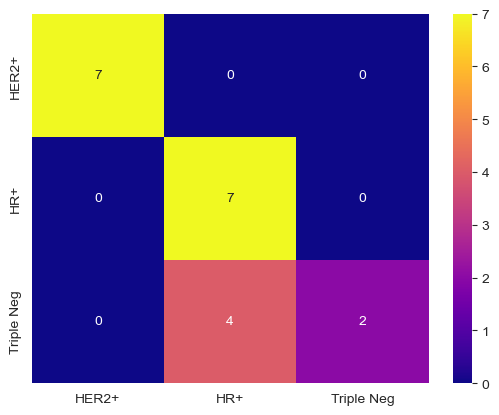

In [92]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_hat)
labels = ["HER2+", "HR+", "Triple Neg"]
sns.heatmap(cm, annot=True, cmap="plasma", fmt="d", xticklabels=labels, yticklabels=labels)

In [93]:
# Create a classification report
cr1 = classification_report(y_test, y_test_hat)
print(cr1)


              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         7
         HR+       0.64      1.00      0.78         7
  Triple Neg       1.00      0.33      0.50         6

    accuracy                           0.80        20
   macro avg       0.88      0.78      0.76        20
weighted avg       0.87      0.80      0.77        20



In [94]:
import pickle
pickle.dump(knn, open('rfe_knn.pkl', 'wb'))